In [1]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps

In [54]:
#%------------- Set the paths
path1 = "../../FESOM_data/channel/"
mesh_fn = "fesom.mesh.diag.nc"
u_path = 'u.fesom.2005.nc'
v_path = 'v.fesom.2005.nc'
out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'UVW_FESOM_track'

#%------------- Particles
## Set the number of particles
num_particles = 1000

## Set the location of the particles 
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))

## set the tracking time
days = 300
minutes = 5

## record the particles every timestep of
hours=4

In [2]:
ds_mesh = xr.open_dataset(path1+mesh_fn)
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

#corners
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)

max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range

near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)


elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

## assign coordinates to the mesh
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)
#nearest neighbour interpolation
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')

channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

# w_lon = number_lon
# w_lat = number_lat
# w_lon = int(2*51.5)
# w_lat = int(2*206)

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))

#reorder the lat and lon into a C grid
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)

#select the grid elements
grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

## modify the mesh for nodes and 
ds_mesh = ds_mesh.assign_coords(
    lat=("nod2", ds_mesh.lat.data.flatten()),
    lon=("nod2", ds_mesh.lon.data.flatten()),
)
#
# Ensure the xoak index 
ds_mesh.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")

#-------------get the nod2grids
#grid_nodes
grid_nodes = ds_mesh.xoak.sel(
    lat = target_lat,
    lon = target_lon,
).nod2

## Equal depth levels

In [3]:
za = ds_mesh.nz.values #41
zb = ds_mesh.nz1.values #40

zc = np.array(sorted(np.concatenate((za, zb))))
#print(zc)

zg = np.sort(np.hstack((0.5 * (zc[0:-1] + zc[1:]), zc)))

#nz grid 
nz_grid = ds_mesh.sel(nz = zg, method = 'nearest').nz
print(nz_grid.astype(int))

nz1_grid = ds_mesh.sel(nz1 = zg, method = 'nearest').nz1
print(nz1_grid.astype(int))

<xarray.DataArray 'nz' (nz: 161)> Size: 1kB
array([   0,    0,    9,    9,    9,    9,    9,   18,   18,   18,   18,
         29,   29,   29,   41,   41,   41,   41,   55,   55,   55,   55,
         69,   69,   69,   69,   85,   85,   85,   85,  103,  103,  103,
        103,  122,  122,  122,  122,  144,  144,  144,  144,  144,  167,
        167,  167,  193,  193,  193,  193,  221,  221,  221,  221,  252,
        252,  252,  252,  252,  287,  287,  287,  287,  324,  324,  324,
        324,  366,  366,  366,  412,  412,  412,  412,  462,  462,  462,
        462,  517,  517,  517,  517,  578,  578,  578,  578,  578,  645,
        645,  645,  718,  718,  718,  718,  799,  799,  799,  799,  888,
        888,  888,  888,  986,  986,  986,  986,  986, 1094, 1094, 1094,
       1212, 1212, 1212, 1212, 1343, 1343, 1343, 1343, 1486, 1486, 1486,
       1486, 1644, 1644, 1644, 1644, 1644, 1817, 1817, 1817, 2008, 2008,
       2008, 2008, 2008, 2218, 2218, 2218, 2449, 2449, 2449, 2449, 2703,
       

## Load the data U,V,W

In [4]:
ds_u = xr.open_mfdataset(path1+u_path,
                         chunks ={'time':1, 'nz1': 1}).isel(time=slice(0,4))
# first selecting only the surface nz1=0
ds_v = xr.open_mfdataset(path1+v_path,
                         chunks = {'time':1, 'nz1':1}).isel(time=slice(0,4))

ds_w = xr.open_mfdataset(path1+w_path,
                         chunks = {'time':1, 'nz':1}).isel(time=slice(0,4))


/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [5]:
U_grid = ds_u.u.isel(elem=grid_elems - 1).interp(nz1=nz1_grid,method = 'nearest') 
V_grid = ds_v.v.isel(elem=grid_elems - 1).interp(nz1=nz1_grid,method = 'nearest') 
W_grid = ds_w.w.isel(nod2=grid_nodes - 1).interp(nz=nz_grid,method = 'nearest')

In [6]:
print(U_grid.shape)
print(V_grid.shape)
print(W_grid.shape)

(4, 161, 144, 584)
(4, 161, 144, 584)
(4, 161, 144, 584)


In [7]:
ds_uv_grid= xr.Dataset({
    'U':U_grid,
    "V":V_grid,
    "W":W_grid,
})

In [8]:
ds_uv_grid
## Keep only one Z and drop the other one

<xarray.Dataset> Size: 655MB
Dimensions:           (time: 4, grid_lon: 144, grid_lat: 584, nz1: 161, nz: 161)
Coordinates: (12/13)
  * time              (time) datetime64[ns] 32B 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
    ...                ...
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5
  * nz1               (nz1) float64 1kB 4.519 4.519 ... 3.814e+03 3.814e+03
    lon               (grid_lon, grid_lat) float64 673kB 0.0 0.0 ... 4.406 4.406
    lat               (grid_lon, grid_lat) float64 673kB 0.0 0.0 ... 17.9 17.9
    nod2              (grid_lon, grid_lat) int64 673kB 1 1 2 ... 10608 10608
  * nz                (nz) float64 1kB 0.0 0.0 9.038 ... 3.628e+03 4e+03 4e+03
Data variables:
    U                 (time, nz1, grid_lon, grid_lat) float32 217MB dask.array<chunksize=(1, 161, 36, 584), meta=np.ndarray>
    V                 (time, nz1, grid_lon, grid_lat) float32 217MB dask.array<chunksize=(1, 161, 36, 584), meta=np.ndarray>
    W                 (time, nz, grid_lon, grid_lat) float32 217MB dask.array<chunksize=(1, 161, 18, 584), meta=np.ndarray>

In [9]:
ds_uv_grid = ds_uv_grid.drop_vars('nz1')

In [10]:
ds_uv_grid['U'] = ds_uv_grid['U'].rename({'nz1':'nz'})
ds_uv_grid['V'] = ds_uv_grid['V'].rename({'nz1':'nz'})

In [29]:
ds_uv_grid = ds_uv_grid.compute()

In [28]:
#print(ds_uv_grid['U'].data.chunks)

((1, 1, 1, 1), (161,), (36, 36, 36, 36), (584,))


## Now Parcels

In [14]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4
from datetime import timedelta
import numpy as np
from parcels import FieldSet

In [30]:
fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','nz','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V", "W":"W"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'depth':'nz',
                'time':'time',
               },
    time_periodic=False,
    allow_time_extrapolation=True,
)

In [39]:
ds_uv_grid.nz

<xarray.DataArray 'nz' (nz: 161)> Size: 1kB
array([   0.     ,    0.     ,    9.03766,    9.03766,    9.03766,    9.03766,
          9.03766,   18.9791 ,   18.9791 ,   18.9791 ,   18.9791 ,   29.9146 ,
         29.9146 ,   29.9146 ,   41.9438 ,   41.9438 ,   41.9438 ,   41.9438 ,
         55.1758 ,   55.1758 ,   55.1758 ,   55.1758 ,   69.731  ,   69.731  ,
         69.731  ,   69.731  ,   85.7418 ,   85.7418 ,   85.7418 ,   85.7418 ,
        103.354  ,  103.354  ,  103.354  ,  103.354  ,  122.727  ,  122.727  ,
        122.727  ,  122.727  ,  144.037  ,  144.037  ,  144.037  ,  144.037  ,
        144.037  ,  167.478  ,  167.478  ,  167.478  ,  193.264  ,  193.264  ,
        193.264  ,  193.264  ,  221.628  ,  221.628  ,  221.628  ,  221.628  ,
        252.828  ,  252.828  ,  252.828  ,  252.828  ,  252.828  ,  287.149  ,
        287.149  ,  287.149  ,  287.149  ,  324.901  ,  324.901  ,  324.901  ,
        324.901  ,  366.429  ,  366.429  ,  366.429  ,  412.11   ,  412.11   ,
        412.11   ,  412.11   ,  462.358  ,  462.358  ,  462.358  ,  462.358  ,
        517.632  ,  517.632  ,  517.632  ,  517.632  ,  578.433  ,  578.433  ,
        578.433  ,  578.433  ,  578.433  ,  645.314  ,  645.314  ,  645.314  ,
        718.883  ,  718.883  ,  718.883  ,  718.883  ,  799.809  ,  799.809  ,
        799.809  ,  799.809  ,  888.827  ,  888.827  ,  888.827  ,  888.827  ,
        986.747  ,  986.747  ,  986.747  ,  986.747  ,  986.747  , 1094.46   ,
       1094.46   , 1094.46   , 1212.94   , 1212.94   , 1212.94   , 1212.94   ,
       1343.28   , 1343.28   , 1343.28   , 1343.28   , 1486.64   , 1486.64   ,
       1486.64   , 1486.64   , 1644.34   , 1644.34   , 1644.34   , 1644.34   ,
       1644.34   , 1817.81   , 1817.81   , 1817.81   , 2008.63   , 2008.63   ,
       2008.63   , 2008.63   , 2008.63   , 2218.53   , 2218.53   , 2218.53   ,
       2449.43   , 2449.43   , 2449.43   , 2449.43   , 2703.41   , 2703.41   ,
       2703.41   , 2703.41   , 2982.78   , 2982.78   , 2982.78   , 2982.78   ,
       3290.1    , 3290.1    , 3290.1    , 3290.1    , 3628.15   , 3628.15   ,
       3628.15   , 3628.15   , 3628.15   , 4000.     , 4000.     ])
Coordinates:
  * nz       (nz) float64 1kB 0.0 0.0 9.038 9.038 ... 3.628e+03 4e+03 4e+03
Attributes:
    long_name:      depth of levels
    standard_name:  
    units:          meters
    positive:       down

## Halo

In [55]:
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

## Initiate particles

In [56]:
#Init particle set
depth = np.random.uniform(10,50, size=num_particles)  # Choose random depths
#time = np.repeat(ds_uv_grid.time[0], num_particles)  # Assign the same time to all particles

pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lon = lon_start,
    lat = lat_start,
    depth=depth,
    #time=time
) 

# pset = parcels.ParticleSet.from_line(
#     fieldset=fieldset,
#     pclass=parcels.JITParticle,
#     size=10,
#     start=(1.9, 52.5),
#     finish=(3.4, 51.6),
#     depth=1,
# )

# lon = np.random.uniform(2, 3, size=num_particles)  # Longitudes between 2 and 3
# lat = np.random.uniform(7.5, 12.5, size=num_particles)  # Latitudes between 7.5 and 12.5
# depth = np.random.choice(ds_uv_grid.nz, size=num_particles)  # Choose random depths

# lon_start = np.random.uniform(2,3,size=(num_particles,)) 
# lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))


In [57]:
output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [58]:
## Execute particles
pset.execute(
    [AdvectionRK4,periodicBC],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)
## check out a different advection squeme

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/UVW_FESOM_track.zarr.
100%|█████████████████████████████████████████████| 25920000.0/25920000.0 [09:01<00:00, 47827.45it/s]


## Make a plot

In [59]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [60]:
out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
#out_fn = 'UV_tracking_fesom'

In [61]:
ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 36MB
Dimensions:     (trajectory: 1000, obs: 1800)
Coordinates:
  * obs         (obs) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * trajectory  (trajectory) int64 8kB 1000 1001 1002 1003 ... 1997 1998 1999
Data variables:
    lat         (trajectory, obs) float32 7MB 9.43 9.422 9.416 ... 12.3 12.34
    lon         (trajectory, obs) float32 7MB 2.925 2.957 2.987 ... 4.1 4.101
    time        (trajectory, obs) datetime64[ns] 14MB 2005-01-01T23:50:00 ......
    z           (trajectory, obs) float32 7MB 44.01 44.01 44.01 ... 14.97 14.97
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

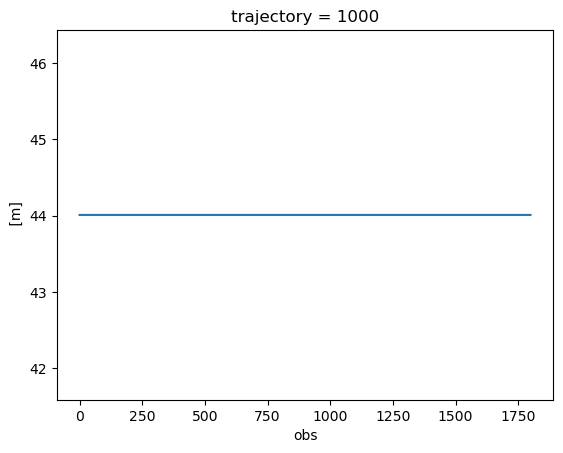

In [82]:
ds_traj.isel(trajectory=0).z.plot()

<Axes: xlabel='lon'>

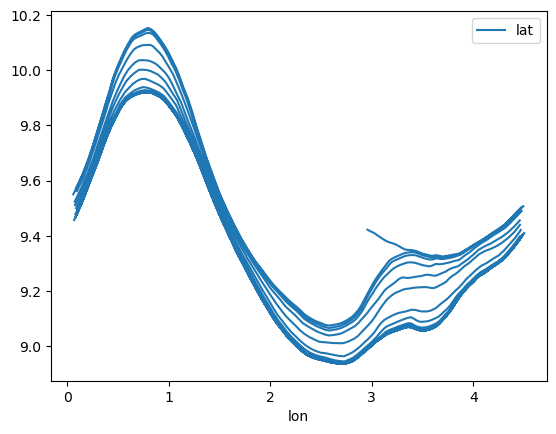

In [80]:
## Pre plot
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)
ds_traj_nowrap.isel(trajectory=0).to_pandas().plot.line(
    x='lon', y='lat',
)

In [62]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

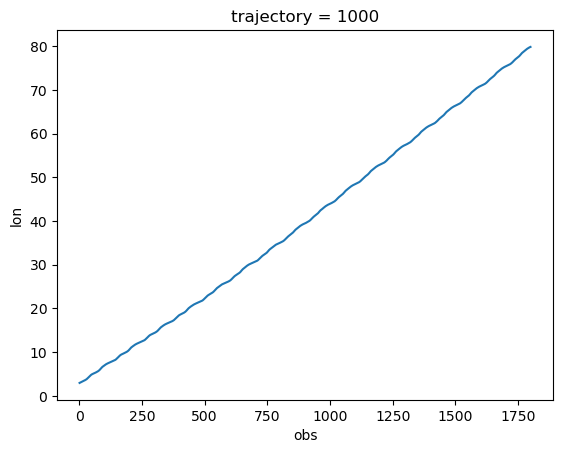

In [70]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
lon_unrolled.isel(trajectory=0).plot()

In [71]:
Nx = 45 #~4.5
Ny = 180 #~18.0

In [72]:
#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)


In [73]:
lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds, lat_bds

((0, 112), (0, 18))

In [ ]:
dens = np.zeros((Ny,Nx), dtype=int)

for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Nx,Ny]
    dens[*pos.T[::-1]] +=count
    #break